# Trabajo Práctico 1 : Reservas de Hotel


## Librerias


In [136]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.metrics import f1_score,  recall_score, precision_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential


np.random.seed(1)
tf.random.set_seed(1)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [114]:
def mostrar_scores(y_test, y_prediccion):
    accuracy = accuracy_score(y_test,y_prediccion)
    recall = recall_score(y_test,y_prediccion)
    f1 = f1_score(y_test,y_prediccion,)
    precision = precision_score(y_test,y_prediccion)

    print("Accuracy: "+str(accuracy))
    print("Recall: "+str(recall))
    print("Precision: "+str(precision))
    print("f1 score: "+str(f1))

## Redes Neuronales

Importamos el dataset y las librerias necesarias para el analisis. Conservamos el mismo procesamiento de datos que en el del chapter 1.

In [115]:
df_redes = pd.read_csv('dataframe_chp1.csv')

In [116]:
df_a_utilizar = df_redes.copy()

Inicialmente vamos a utilizar el mismo dataset con las mismas features que veniamos porbando en los demas capitulos. Cabe recalcar que en un futuro quizas cambiemos estas features ya que no sabemos como se van a comportar con nuestro modelo de redes neuronales.

In [117]:
columns = [
    'hotel',
    'lead_time',
    'year',
    'week_number',
    'meal_type',
    'country',
    'market_segment',
    'is_repeated_guest',
    'previous_cancellations',
    'booking_changes',
    'deposit_type',
    'agent_id',
    'days_in_waiting_list',
    'customer_type',
    'average_daily_rate',
    'required_car_parking_spaces',
    'total_of_special_requests',
    'is_canceled',
    'total_people'
]

dummy_columns = [
    'hotel',
    'deposit_type',
    'market_segment',
    'agent_id',
    'country',
    'customer_type',
    'meal_type',
]

In [118]:
agentes = df_a_utilizar[['agent_id']].value_counts().reset_index()

agentes.columns = ['agent_id', 'cantidad']
agentes_mayoritarios = agentes[agentes['cantidad'] > 20]
agentes_minoritarios = agentes[agentes['cantidad'] <= 20]

df_agentes_mayoritarios = df_a_utilizar[df_a_utilizar['agent_id'].isin(agentes_mayoritarios['agent_id'])]
df_agentes_minoritarios = df_a_utilizar[df_a_utilizar['agent_id'].isin(agentes_minoritarios['agent_id'])]
df_agentes_minoritarios.loc[df_a_utilizar['agent_id'].isin(agentes_minoritarios['agent_id']), 'agent_id'] = 'Otros'

df_agentes = pd.concat([df_agentes_mayoritarios, df_agentes_minoritarios])

paises = df_agentes[['country']].value_counts().reset_index()
paises.columns = ['country', 'cantidad']
paises_mayoritarios = paises[paises['cantidad'] > 15]
paises_minoritarios = paises[paises['cantidad'] <= 15]

df_paises_mayoritarios = df_agentes[df_agentes['country'].isin(paises_mayoritarios['country'])]
df_paises_minoritarios = df_agentes[df_agentes['country'].isin(paises_minoritarios['country'])]
df_paises_minoritarios.loc[df_agentes['country'].isin(paises_minoritarios['country']), 'country'] = 'Otros'

df_encode = pd.concat([df_paises_mayoritarios, df_paises_minoritarios])

filtrado = df_encode[columns]

df_con_dummies = pd.get_dummies(filtrado, columns=dummy_columns, drop_first=True)


df_con_dummies['cuarto_correcto'] = df_redes['reserved_room_type'] == df_redes['assigned_room_type']
df_con_dummies['cuarto_correcto'] = df_con_dummies['cuarto_correcto'].apply(lambda x: 1 if x == True else 0)

df_trabajo_x = df_con_dummies.drop(['is_canceled'], axis='columns', inplace=False)
df_trabajo_y = df_con_dummies['is_canceled'].copy()

Utilizamos un split de data de 0.7 para train y 0.3 para test.

In [119]:
x_train, x_test, y_train, y_test = train_test_split(df_trabajo_x,
                                                    df_trabajo_y,
                                                    test_size=0.3,
                                                    random_state=11457,
                                                    stratify=df_a_utilizar["is_canceled"].values
                                                    )

Usamos el min max scaler para escalar los datos ya que esto mejora la convergencia de la red neuronal, iguala la influencia de las caracteristicas y ademas evita problemas numericos debido a que algunas funciones de activacion no trabajan muy bien si los valores de entrada son muy grandes.

In [120]:
escalador=MinMaxScaler()

x_train_escalado_min_max=pd.DataFrame(escalador.fit_transform(x_train))
x_test_escalado_min_max=pd.DataFrame(escalador.transform(x_test))

Ademas, lo bueno del min max es que nuestras variables dummies van a seguir estando exactamente igual a como estaban antes del escalado.

In [9]:
escalador=StandardScaler()
escalador.fit(pd.DataFrame(x_train))

x_train_escalado_std=pd.DataFrame(escalador.transform(x_train))
x_test_escalado_std=pd.DataFrame(escalador.transform(x_test))

### Red neuronal básica

Utilizamos el optimizador de Adam ya que investigamos que es de los mejores en este aspecto, ya que combina el optimizador de RMSProp y el de descenso de gradiente estocastico (SGD). 

Epoch 1/10
1218/1218 [==============================] - 1s 616us/step - loss: 0.3871 - accuracy: 0.8107
Epoch 2/10
1218/1218 [==============================] - 1s 580us/step - loss: 0.3318 - accuracy: 0.8393
Epoch 3/10
1218/1218 [==============================] - 1s 579us/step - loss: 0.3215 - accuracy: 0.8449
Epoch 4/10
1218/1218 [==============================] - 1s 486us/step - loss: 0.3143 - accuracy: 0.8475
Epoch 5/10
1218/1218 [==============================] - 1s 483us/step - loss: 0.3082 - accuracy: 0.8518
Epoch 6/10
1218/1218 [==============================] - 1s 472us/step - loss: 0.3035 - accuracy: 0.8553
Epoch 7/10
1218/1218 [==============================] - 1s 488us/step - loss: 0.2986 - accuracy: 0.8560
Epoch 8/10
1218/1218 [==============================] - 1s 474us/step - loss: 0.2940 - accuracy: 0.8592
Epoch 9/10
1218/1218 [==============================] - 1s 574us/step - loss: 0.2901 - accuracy: 0.8623
Epoch 10/10
522/522 [==============================] - 0s 285us/

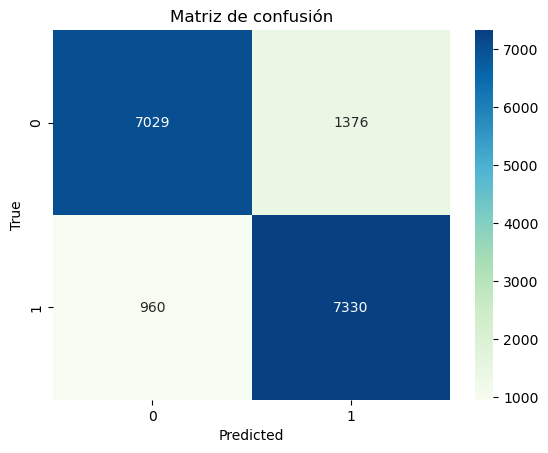

1218/1218 [==============================] - 0s 317us/step
Accuracy: 0.8704915928635605
Recall: 0.8993403625409028
Precision: 0.8478601508177456
f1 score: 0.8728418399495904


In [160]:
modelo = keras.Sequential([
   keras.layers.Dense(128, input_shape=(x_train_escalado_min_max.shape[1],), activation='relu'),
   keras.layers.Dense(1, activation='sigmoid')
])

modelo.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

modelo.fit(x_train_escalado_min_max, y_train, epochs=10)

y_prediccion = modelo.predict(x_test_escalado_min_max)
mostrar_scores(y_test, y_prediccion.round())

tabla = confusion_matrix(y_test, y_prediccion.round())
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


y_prediccion_train = modelo.predict(x_train_escalado_min_max)
mostrar_scores(y_train, y_prediccion_train.round())

Podemos ver que el Recall es considerablemente mas elevado que el Precision, lo cual nos indica que el modelo esta prediciendo correctamente los casos negativos, pero no tanto los positivos.

### Red neuronal con capas de dropout

Ahora agregamos dropout, el cual es una tecnica de regularizacion que se utiliza en redes neuronales para evitar el overfitting.

Epoch 1/10
1218/1218 [==============================] - 1s 606us/step - loss: 0.3952 - accuracy: 0.8087
Epoch 2/10
1218/1218 [==============================] - 1s 504us/step - loss: 0.3379 - accuracy: 0.8346
Epoch 3/10
1218/1218 [==============================] - 1s 502us/step - loss: 0.3273 - accuracy: 0.8403
Epoch 4/10
1218/1218 [==============================] - 1s 503us/step - loss: 0.3196 - accuracy: 0.8453
Epoch 5/10
1218/1218 [==============================] - 1s 500us/step - loss: 0.3141 - accuracy: 0.8482
Epoch 6/10
1218/1218 [==============================] - 1s 539us/step - loss: 0.3089 - accuracy: 0.8523
Epoch 7/10
1218/1218 [==============================] - 1s 499us/step - loss: 0.3038 - accuracy: 0.8543
Epoch 8/10
1218/1218 [==============================] - 1s 618us/step - loss: 0.2996 - accuracy: 0.8571
Epoch 9/10
1218/1218 [==============================] - 1s 503us/step - loss: 0.2968 - accuracy: 0.8590
Epoch 10/10
522/522 [==============================] - 0s 284us/

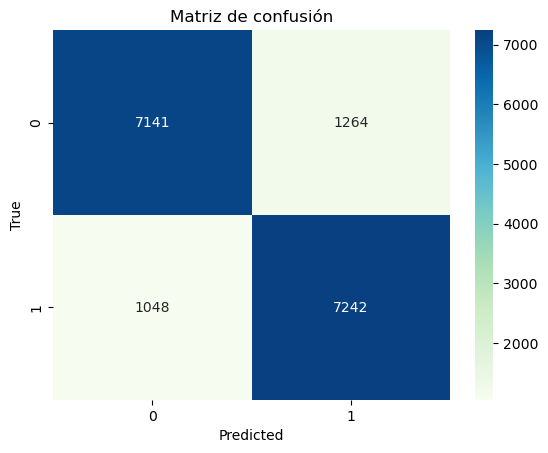

1218/1218 [==============================] - 0s 332us/step
Accuracy: 0.8695417789757413
Recall: 0.8874461122941879
Precision: 0.8542572871356432
f1 score: 0.8705354868293675


In [38]:
modelo = keras.Sequential([
    keras.layers.Dense(128, input_shape=(x_train_escalado_min_max.shape[1],), activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')

])

modelo.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

modelo.fit(x_train_escalado_min_max, y_train, epochs=10)

y_prediccion = modelo.predict(x_test_escalado_min_max)
mostrar_scores(y_test, y_prediccion.round())

tabla = confusion_matrix(y_test, y_prediccion.round())
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


y_prediccion_train = modelo.predict(x_train_escalado_min_max)
mostrar_scores(y_train, y_prediccion_train.round())

En este caso nos presentamos con el mismo problema que el modelo anterior, donde el recall es mucho mas alto que el precision. Cabe destacar que el conjunto de train es mas cercano en f1 al conjunto de test que el modelo anterior, indicando menos overfitting.

### Redes neuronales con capas de dropout, regularizacion L1 y L2

La regularizacion l1 y l2 tambien son tecnicas de regularizacion que se utilizan para evitar el overfitting. La regularizacion l1 es la suma de los valores absolutos de los coeficientes multiplicados por un factor lambda. La regularizacion l2 es la suma de los valores al cuadrado de los coeficientes multiplicados por un factor lambda.

#### Con L2 y dropout

In [27]:
modelo = keras.Sequential([
    keras.layers.Dense(128, input_shape=(x_train_escalado_min_max.shape[1],), activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')

])

modelo.compile(optimizer='adam',   
                loss='binary_crossentropy',
                metrics=['accuracy'])

modelo.fit(x_train_escalado_min_max, y_train, epochs=10)

y_prediccion = modelo.predict(x_test_escalado_min_max)
mostrar_scores(y_test, y_prediccion.round())

tabla = confusion_matrix(y_test, y_prediccion.round())
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

y_prediccion_train = modelo.predict(x_train_escalado_min_max)
mostrar_scores(y_train, y_prediccion_train.round())


Epoch 1/10
1218/1218 [==============================] - 1s 538us/step - loss: 0.4416 - accuracy: 0.8044
Epoch 2/10
1218/1218 [==============================] - 1s 593us/step - loss: 0.3813 - accuracy: 0.8293
Epoch 3/10
1218/1218 [==============================] - 1s 611us/step - loss: 0.3712 - accuracy: 0.8323
Epoch 4/10
1218/1218 [==============================] - 1s 526us/step - loss: 0.3640 - accuracy: 0.8352
Epoch 5/10
1218/1218 [==============================] - 1s 557us/step - loss: 0.3602 - accuracy: 0.8385
Epoch 6/10
1218/1218 [==============================] - 1s 559us/step - loss: 0.3576 - accuracy: 0.8386
Epoch 7/10
1218/1218 [==============================] - 1s 577us/step - loss: 0.3543 - accuracy: 0.8389
Epoch 8/10
1218/1218 [==============================] - 1s 607us/step - loss: 0.3526 - accuracy: 0.8401
Epoch 9/10
1218/1218 [==============================] - 1s 507us/step - loss: 0.3495 - accuracy: 0.8428
Epoch 10/10
522/522 [==============================] - 0s 274us/

#### Con L1 y dropout

Epoch 1/10
1218/1218 [==============================] - 1s 622us/step - loss: 0.5949 - accuracy: 0.7878
Epoch 2/10
1218/1218 [==============================] - 1s 655us/step - loss: 0.4538 - accuracy: 0.8166
Epoch 3/10
1218/1218 [==============================] - 1s 711us/step - loss: 0.4340 - accuracy: 0.8229
Epoch 4/10
1218/1218 [==============================] - 1s 576us/step - loss: 0.4221 - accuracy: 0.8258
Epoch 5/10
1218/1218 [==============================] - 1s 633us/step - loss: 0.4145 - accuracy: 0.8270
Epoch 6/10
1218/1218 [==============================] - 1s 548us/step - loss: 0.4068 - accuracy: 0.8294
Epoch 7/10
1218/1218 [==============================] - 1s 547us/step - loss: 0.4035 - accuracy: 0.8328
Epoch 8/10
1218/1218 [==============================] - 1s 510us/step - loss: 0.3994 - accuracy: 0.8323
Epoch 9/10
1218/1218 [==============================] - 1s 516us/step - loss: 0.3956 - accuracy: 0.8334
Epoch 10/10
522/522 [==============================] - 0s 285us/

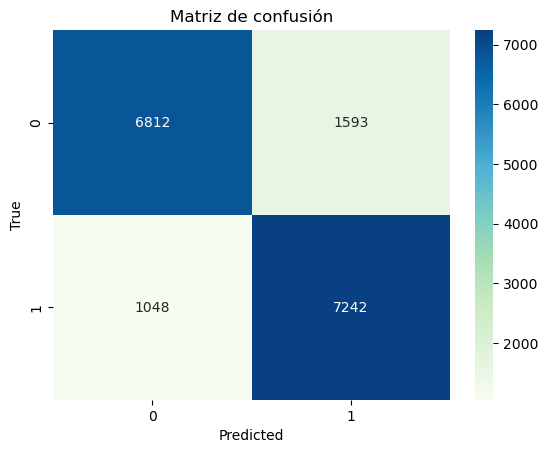

1218/1218 [==============================] - 0s 389us/step
Accuracy: 0.8408933384674625
Recall: 0.8755518620474732
Precision: 0.8159639866402052
f1 score: 0.8447083583884546


In [39]:
modelo = keras.Sequential([
    keras.layers.Dense(128, input_shape=(x_train_escalado_min_max.shape[1],), activation='relu', kernel_regularizer=keras.regularizers.l1(0.001)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')

])

modelo.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

modelo.fit(x_train_escalado_min_max, y_train, epochs=10)

y_prediccion = modelo.predict(x_test_escalado_min_max)
mostrar_scores(y_test, y_prediccion.round())

tabla = confusion_matrix(y_test, y_prediccion.round())
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


y_prediccion_train = modelo.predict(x_train_escalado_min_max)
mostrar_scores(y_train, y_prediccion_train.round())

En este caso la diferencia entre Recall y Precision en muchisimo mas elevada, esto puede ser debido a la regularizacion.

#### Con dropout, L1 y L2

Epoch 1/10
1218/1218 [==============================] - 1s 635us/step - loss: 0.6059 - accuracy: 0.7884
Epoch 2/10
1218/1218 [==============================] - 1s 566us/step - loss: 0.4589 - accuracy: 0.8144
Epoch 3/10
1218/1218 [==============================] - 1s 544us/step - loss: 0.4402 - accuracy: 0.8198
Epoch 4/10
1218/1218 [==============================] - 1s 544us/step - loss: 0.4284 - accuracy: 0.8238
Epoch 5/10
1218/1218 [==============================] - 1s 569us/step - loss: 0.4207 - accuracy: 0.8260
Epoch 6/10
1218/1218 [==============================] - 1s 564us/step - loss: 0.4129 - accuracy: 0.8274
Epoch 7/10
1218/1218 [==============================] - 1s 614us/step - loss: 0.4099 - accuracy: 0.8275
Epoch 8/10
1218/1218 [==============================] - 1s 600us/step - loss: 0.4048 - accuracy: 0.8289
Epoch 9/10
1218/1218 [==============================] - 1s 558us/step - loss: 0.4024 - accuracy: 0.8308
Epoch 10/10
522/522 [==============================] - 0s 288us/

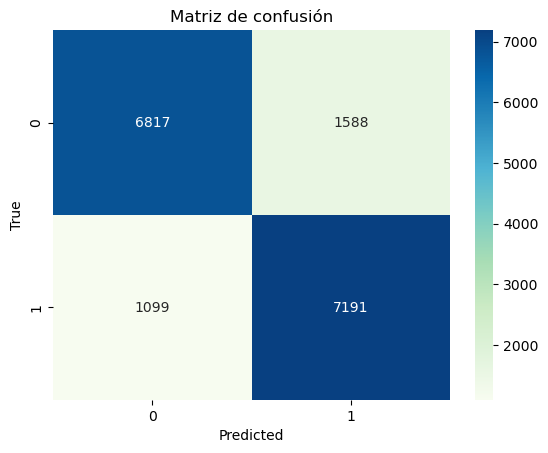

1218/1218 [==============================] - 0s 319us/step
Accuracy: 0.839276087793608
Recall: 0.8734223237936944
Precision: 0.8147286821705426
f1 score: 0.8430551725866693


In [40]:
modelo = keras.Sequential([
    keras.layers.Dense(128, input_shape=(x_train_escalado_min_max.shape[1],), activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=0.001, l2=0.001)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')

])

modelo.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

modelo.fit(x_train_escalado_min_max, y_train, epochs=10)

y_prediccion = modelo.predict(x_test_escalado_min_max)
mostrar_scores(y_test, y_prediccion.round())

tabla = confusion_matrix(y_test, y_prediccion.round())
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


y_prediccion_train = modelo.predict(x_train_escalado_min_max)
mostrar_scores(y_train, y_prediccion_train.round())

Notamos la misma diferencia que en el caso anterior, confirmando la teoria que es la regularizacion.

### Red neuronal con batch normalization

Esta nueva caracteristica, batch normalization, leimos que ayuda a mejorar la velocidad de convergencia y estabilidad del algortimo. 

Epoch 1/10
1218/1218 [==============================] - 1s 715us/step - loss: 0.6932 - accuracy: 0.8065
Epoch 2/10
1218/1218 [==============================] - 1s 673us/step - loss: 0.4592 - accuracy: 0.8191
Epoch 3/10
1218/1218 [==============================] - 1s 637us/step - loss: 0.4288 - accuracy: 0.8243
Epoch 4/10
1218/1218 [==============================] - 1s 671us/step - loss: 0.4142 - accuracy: 0.8307
Epoch 5/10
1218/1218 [==============================] - 1s 616us/step - loss: 0.4055 - accuracy: 0.8320
Epoch 6/10
1218/1218 [==============================] - 1s 617us/step - loss: 0.3996 - accuracy: 0.8315
Epoch 7/10
1218/1218 [==============================] - 1s 733us/step - loss: 0.3974 - accuracy: 0.8341
Epoch 8/10
1218/1218 [==============================] - 1s 620us/step - loss: 0.3968 - accuracy: 0.8338
Epoch 9/10
1218/1218 [==============================] - 1s 630us/step - loss: 0.3965 - accuracy: 0.8321
Epoch 10/10
522/522 [==============================] - 0s 297us/

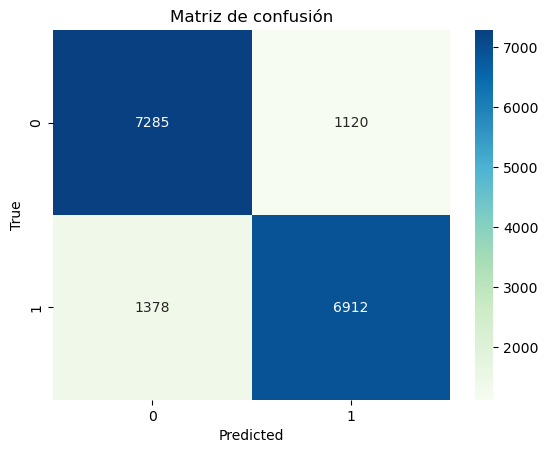

1218/1218 [==============================] - 0s 345us/step
Accuracy: 0.8515979976896418
Recall: 0.8383628525424609
Precision: 0.858107389686337
f1 score: 0.8481202217376455


In [41]:
modelo = keras.Sequential([

    keras.layers.Dense(128, input_shape=(x_train_escalado_min_max.shape[1],), activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=0.001, l2=0.001)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')

])

modelo.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

modelo.fit(x_train_escalado_min_max, y_train, epochs=10)

y_prediccion = modelo.predict(x_test_escalado_min_max)
mostrar_scores(y_test, y_prediccion.round())

tabla = confusion_matrix(y_test, y_prediccion.round())
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


y_prediccion_train = modelo.predict(x_train_escalado_min_max)
mostrar_scores(y_train, y_prediccion_train.round())

Este es el primer caso donde la precision es mayor que el recall, mirando la matriz de confusion podemos observar tambien que nuestro modelo tiene a predecir mas casos negativos que positivos.

### Red neuronal con early stopping

El early stopping es otro parametro para evitar el overfit. La idea de esto es que si el modelo no mejora despues de cierta cantidad de epochs, se detiene el entrenamiento.

Epoch 1/10
1218/1218 [==============================] - 1s 637us/step - loss: 0.6917 - accuracy: 0.8068
Epoch 2/10
1218/1218 [==============================] - 1s 749us/step - loss: 0.4592 - accuracy: 0.8206
Epoch 3/10
1218/1218 [==============================] - 1s 647us/step - loss: 0.4340 - accuracy: 0.8223
Epoch 4/10
1218/1218 [==============================] - 1s 642us/step - loss: 0.4205 - accuracy: 0.8274
Epoch 5/10
1218/1218 [==============================] - 1s 634us/step - loss: 0.4126 - accuracy: 0.8285
Epoch 6/10
1218/1218 [==============================] - 1s 647us/step - loss: 0.4061 - accuracy: 0.8280
Epoch 7/10
1218/1218 [==============================] - 1s 616us/step - loss: 0.4036 - accuracy: 0.8295
Epoch 8/10
1218/1218 [==============================] - 1s 657us/step - loss: 0.4032 - accuracy: 0.8309
Epoch 9/10
1218/1218 [==============================] - 1s 623us/step - loss: 0.4017 - accuracy: 0.8297
Epoch 10/10
522/522 [==============================] - 0s 306us/

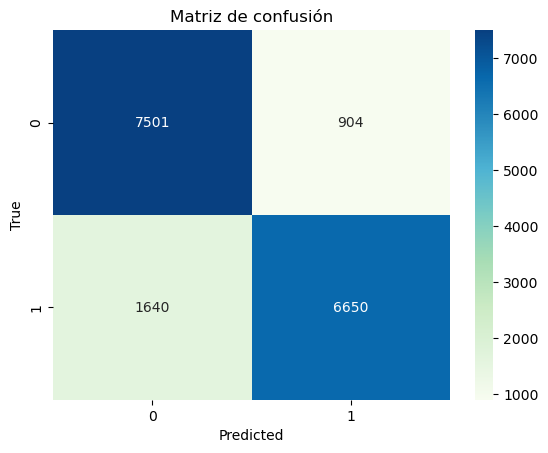

1218/1218 [==============================] - 0s 377us/step
Accuracy: 0.8467205750224618
Recall: 0.8050693398431413
Precision: 0.8748165707190427
f1 score: 0.8384950366503476


In [42]:
modelo = keras.Sequential([
    keras.layers.Dense(128, input_shape=(x_train_escalado_min_max.shape[1],), activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=0.001, l2=0.001)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')

])

modelo.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

modelo.fit(x_train_escalado_min_max, y_train, epochs=10, callbacks=[early_stopping])

y_prediccion = modelo.predict(x_test_escalado_min_max)
mostrar_scores(y_test, y_prediccion.round())

tabla = confusion_matrix(y_test, y_prediccion.round())
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


y_prediccion_train = modelo.predict(x_train_escalado_min_max)
mostrar_scores(y_train, y_prediccion_train.round())

Aqui podemos notar el mismo caso que el del modelo anterior pero aun mas acentuado, donde la precision es mucho mas alta que el recall.

### Red neuronal con learning rate

Por ultimo, agregamos el learning rate el cual es clave para las redes neuronales. Este parametro es el que determina el tamaño del paso que se da en cada iteracion mientras se busca un minimo de la funcion de perdida. Si el learning rate es muy pequeño, el entrenamiento va a ser muy lento. Si el learning rate es muy grande, el entrenamiento puede no converger o incluso diverger.

Epoch 1/20
1218/1218 [==============================] - 1s 640us/step - loss: 0.6825 - accuracy: 0.8073
Epoch 2/20
1218/1218 [==============================] - 1s 636us/step - loss: 0.4532 - accuracy: 0.8217
Epoch 3/20
1218/1218 [==============================] - 1s 622us/step - loss: 0.4283 - accuracy: 0.8238
Epoch 4/20
1218/1218 [==============================] - 1s 667us/step - loss: 0.4139 - accuracy: 0.8292
Epoch 5/20
1218/1218 [==============================] - 1s 628us/step - loss: 0.4095 - accuracy: 0.8285
Epoch 6/20
1218/1218 [==============================] - 1s 642us/step - loss: 0.4026 - accuracy: 0.8287
Epoch 7/20
1218/1218 [==============================] - 1s 617us/step - loss: 0.3983 - accuracy: 0.8323
Epoch 8/20
1218/1218 [==============================] - 1s 727us/step - loss: 0.3979 - accuracy: 0.8318
Epoch 9/20
1218/1218 [==============================] - 1s 682us/step - loss: 0.3961 - accuracy: 0.8333
Epoch 10/20
1218/1218 [==============================] - 1s 620u

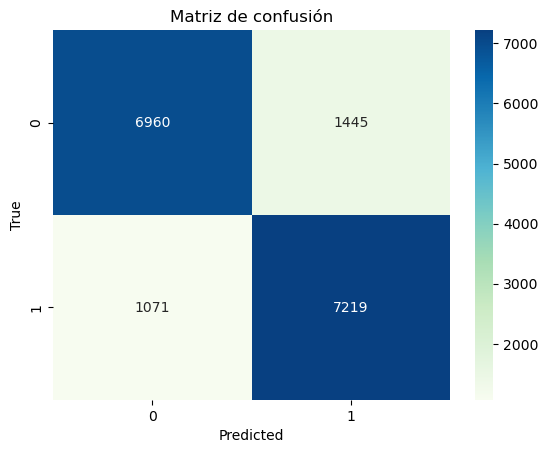

1218/1218 [==============================] - 0s 312us/step
Accuracy: 0.8515979976896418
Recall: 0.8772658806419779
Precision: 0.8316919440614536
f1 score: 0.8538712368241449


In [165]:
modelo = keras.Sequential([
    keras.layers.Dense(128, input_shape=(x_train_escalado_min_max.shape[1],), activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=0.001, l2=0.001)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')

])

modelo.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy'])

modelo.fit(x_train_escalado_min_max, y_train, epochs=20)

y_prediccion = modelo.predict(x_test_escalado_min_max)
mostrar_scores(y_test, y_prediccion.round())

tabla = confusion_matrix(y_test, y_prediccion.round())
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

y_prediccion_train = modelo.predict(x_train_escalado_min_max)
mostrar_scores(y_train, y_prediccion_train.round())

Aqui volvemos al caso inverso, donde no solo el recall es mayor, sino que tambien  hay mas casos en general catalogados como cancelados

Con esto podemos observar como el loss va disminuyendo a medida que pasan los epochs.

Epoch 1/50
1181/1218 [============================>.] - ETA: 0s - loss: 0.4926 - accuracy: 0.7990WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 640us/step - loss: 0.4937 - accuracy: 0.7980
Epoch 2/50
1194/1218 [============================>.] - ETA: 0s - loss: 0.4922 - accuracy: 0.7993WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 723us/step - loss: 0.4921 - accuracy: 0.7991
Epoch 3/50
1200/1218 [============================>.] - ETA: 0s - loss: 0.4912 - accuracy: 0.7981WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 795us/step - loss: 0.4908 - accuracy: 0.7984
Epoch 4/50
1141/1218 [===========================>..] - ETA: 0s - loss: 0.4928 - accuracy: 0.7996WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 762us/step - loss: 0.4914 - accuracy: 0.8002
Epoch 5/50
1162/1218 [===========================>..] - ETA: 0s - loss: 0.4877 - accuracy: 0.8028WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 785us/step - loss: 0.4890 - accuracy: 0.8020
Epoch 6/50
1160/1218 [===========================>..] - ETA: 0s - loss: 0.4883 - accuracy: 0.8000WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 652us/step - loss: 0.4888 - accuracy: 0.7995
Epoch 7/50
1216/1218 [============================>.] - ETA: 0s - loss: 0.4853 - accuracy: 0.8011WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 664us/step - loss: 0.4854 - accuracy: 0.8010
Epoch 8/50
1212/1218 [============================>.] - ETA: 0s - loss: 0.4892 - accuracy: 0.8000WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 794us/step - loss: 0.4894 - accuracy: 0.7999
Epoch 9/50
1208/1218 [============================>.] - ETA: 0s - loss: 0.4862 - accuracy: 0.8025WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 670us/step - loss: 0.4861 - accuracy: 0.8025
Epoch 10/50
1191/1218 [============================>.] - ETA: 0s - loss: 0.4891 - accuracy: 0.7985WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 725us/step - loss: 0.4891 - accuracy: 0.7984
Epoch 11/50
1216/1218 [============================>.] - ETA: 0s - loss: 0.4874 - accuracy: 0.7987WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 708us/step - loss: 0.4875 - accuracy: 0.7987
Epoch 12/50
1200/1218 [============================>.] - ETA: 0s - loss: 0.4917 - accuracy: 0.7967WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 635us/step - loss: 0.4914 - accuracy: 0.7968
Epoch 13/50
1171/1218 [===========================>..] - ETA: 0s - loss: 0.4869 - accuracy: 0.7976WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 698us/step - loss: 0.4872 - accuracy: 0.7977
Epoch 14/50
1148/1218 [===========================>..] - ETA: 0s - loss: 0.4872 - accuracy: 0.8029WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 659us/step - loss: 0.4864 - accuracy: 0.8035
Epoch 15/50
1208/1218 [============================>.] - ETA: 0s - loss: 0.4853 - accuracy: 0.8011WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 627us/step - loss: 0.4853 - accuracy: 0.8011
Epoch 16/50
1166/1218 [===========================>..] - ETA: 0s - loss: 0.4879 - accuracy: 0.7999WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 647us/step - loss: 0.4876 - accuracy: 0.7997
Epoch 17/50
1175/1218 [===========================>..] - ETA: 0s - loss: 0.4865 - accuracy: 0.8003WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 600us/step - loss: 0.4870 - accuracy: 0.8001
Epoch 18/50
1186/1218 [============================>.] - ETA: 0s - loss: 0.4869 - accuracy: 0.7995WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 636us/step - loss: 0.4876 - accuracy: 0.7994
Epoch 19/50
1174/1218 [===========================>..] - ETA: 0s - loss: 0.4930 - accuracy: 0.7997WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 601us/step - loss: 0.4926 - accuracy: 0.8000
Epoch 20/50
1139/1218 [===========================>..] - ETA: 0s - loss: 0.4871 - accuracy: 0.7986WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 660us/step - loss: 0.4866 - accuracy: 0.7990
Epoch 21/50
1182/1218 [============================>.] - ETA: 0s - loss: 0.4880 - accuracy: 0.8023WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 639us/step - loss: 0.4875 - accuracy: 0.8028
Epoch 22/50
1150/1218 [===========================>..] - ETA: 0s - loss: 0.4911 - accuracy: 0.7985WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 614us/step - loss: 0.4917 - accuracy: 0.7979
Epoch 23/50
1164/1218 [===========================>..] - ETA: 0s - loss: 0.4880 - accuracy: 0.7966WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 606us/step - loss: 0.4877 - accuracy: 0.7966
Epoch 24/50
1168/1218 [===========================>..] - ETA: 0s - loss: 0.4832 - accuracy: 0.7977WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 604us/step - loss: 0.4832 - accuracy: 0.7977
Epoch 25/50
1201/1218 [============================>.] - ETA: 0s - loss: 0.4864 - accuracy: 0.7960WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 805us/step - loss: 0.4861 - accuracy: 0.7961
Epoch 26/50
1188/1218 [============================>.] - ETA: 0s - loss: 0.4916 - accuracy: 0.7945WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 762us/step - loss: 0.4911 - accuracy: 0.7949
Epoch 27/50
1148/1218 [===========================>..] - ETA: 0s - loss: 0.4834 - accuracy: 0.8004WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 702us/step - loss: 0.4848 - accuracy: 0.7993
Epoch 28/50
1214/1218 [============================>.] - ETA: 0s - loss: 0.4844 - accuracy: 0.7949WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 749us/step - loss: 0.4842 - accuracy: 0.7951
Epoch 29/50
1174/1218 [===========================>..] - ETA: 0s - loss: 0.4851 - accuracy: 0.7951WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 643us/step - loss: 0.4845 - accuracy: 0.7952
Epoch 30/50
1193/1218 [============================>.] - ETA: 0s - loss: 0.4878 - accuracy: 0.7931WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 678us/step - loss: 0.4878 - accuracy: 0.7932
Epoch 31/50
1214/1218 [============================>.] - ETA: 0s - loss: 0.4870 - accuracy: 0.7967WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 878us/step - loss: 0.4873 - accuracy: 0.7965
Epoch 32/50
1157/1218 [===========================>..] - ETA: 0s - loss: 0.4903 - accuracy: 0.7942WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 742us/step - loss: 0.4898 - accuracy: 0.7942
Epoch 33/50
1158/1218 [===========================>..] - ETA: 0s - loss: 0.4842 - accuracy: 0.7980WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 655us/step - loss: 0.4843 - accuracy: 0.7979
Epoch 34/50
1178/1218 [============================>.] - ETA: 0s - loss: 0.4884 - accuracy: 0.7963WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 781us/step - loss: 0.4884 - accuracy: 0.7964
Epoch 35/50
1190/1218 [============================>.] - ETA: 0s - loss: 0.4858 - accuracy: 0.7973WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 679us/step - loss: 0.4850 - accuracy: 0.7976
Epoch 36/50
1195/1218 [============================>.] - ETA: 0s - loss: 0.4851 - accuracy: 0.7953WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 820us/step - loss: 0.4849 - accuracy: 0.7954
Epoch 37/50
1210/1218 [============================>.] - ETA: 0s - loss: 0.4883 - accuracy: 0.7947WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 754us/step - loss: 0.4881 - accuracy: 0.7947
Epoch 38/50
1153/1218 [===========================>..] - ETA: 0s - loss: 0.4871 - accuracy: 0.7923WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 702us/step - loss: 0.4875 - accuracy: 0.7926
Epoch 39/50
1164/1218 [===========================>..] - ETA: 0s - loss: 0.4869 - accuracy: 0.7944WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 749us/step - loss: 0.4870 - accuracy: 0.7946
Epoch 40/50
1142/1218 [===========================>..] - ETA: 0s - loss: 0.4871 - accuracy: 0.7955WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 705us/step - loss: 0.4873 - accuracy: 0.7962
Epoch 41/50
1202/1218 [============================>.] - ETA: 0s - loss: 0.4894 - accuracy: 0.7971WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 672us/step - loss: 0.4895 - accuracy: 0.7973
Epoch 42/50
1162/1218 [===========================>..] - ETA: 0s - loss: 0.4885 - accuracy: 0.7978WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 693us/step - loss: 0.4884 - accuracy: 0.7984
Epoch 43/50
1174/1218 [===========================>..] - ETA: 0s - loss: 0.4883 - accuracy: 0.7982WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 643us/step - loss: 0.4880 - accuracy: 0.7985
Epoch 44/50
1201/1218 [============================>.] - ETA: 0s - loss: 0.4873 - accuracy: 0.7974WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 673us/step - loss: 0.4868 - accuracy: 0.7977
Epoch 45/50
1196/1218 [============================>.] - ETA: 0s - loss: 0.4864 - accuracy: 0.7967WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 675us/step - loss: 0.4865 - accuracy: 0.7965
Epoch 46/50
1158/1218 [===========================>..] - ETA: 0s - loss: 0.4835 - accuracy: 0.7953WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 654us/step - loss: 0.4831 - accuracy: 0.7952
Epoch 47/50
1200/1218 [============================>.] - ETA: 0s - loss: 0.4862 - accuracy: 0.7966WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 716us/step - loss: 0.4864 - accuracy: 0.7964
Epoch 48/50
1182/1218 [============================>.] - ETA: 0s - loss: 0.4871 - accuracy: 0.7967WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 730us/step - loss: 0.4877 - accuracy: 0.7962
Epoch 49/50
1190/1218 [============================>.] - ETA: 0s - loss: 0.4864 - accuracy: 0.7977WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 721us/step - loss: 0.4862 - accuracy: 0.7977
Epoch 50/50
1168/1218 [===========================>..] - ETA: 0s - loss: 0.4810 - accuracy: 0.7972WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1218/1218 [==============================] - 1s 734us/step - loss: 0.4811 - accuracy: 0.7970


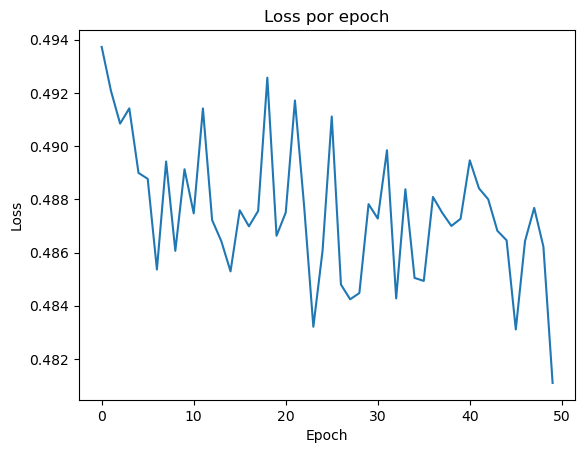

In [122]:
history = modelo.fit(x_train_escalado_min_max, y_train, epochs=50, callbacks=[early_stopping])

plt.plot(history.history['loss'])
plt.title('Loss por epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#### Red neuronal con regularizador L2 y optimizador de Descenso por Gradiente Estocastico con learning rate

Probamos con el optimizador de SGD ya que es el mas basico y en algunos casos puede llegar a obtener mejores resultados que el de Adam.

Epoch 1/60
1218/1218 [==============================] - 1s 462us/step - loss: 0.6795 - accuracy: 0.7186
Epoch 2/60
1218/1218 [==============================] - 1s 489us/step - loss: 0.5589 - accuracy: 0.7858
Epoch 3/60
1218/1218 [==============================] - 1s 498us/step - loss: 0.5163 - accuracy: 0.8019
Epoch 4/60
1218/1218 [==============================] - 1s 489us/step - loss: 0.4952 - accuracy: 0.8119
Epoch 5/60
1218/1218 [==============================] - 1s 576us/step - loss: 0.4817 - accuracy: 0.8185
Epoch 6/60
1218/1218 [==============================] - 1s 462us/step - loss: 0.4719 - accuracy: 0.8225
Epoch 7/60
1218/1218 [==============================] - 1s 545us/step - loss: 0.4637 - accuracy: 0.8245
Epoch 8/60
1218/1218 [==============================] - 1s 522us/step - loss: 0.4569 - accuracy: 0.8259
Epoch 9/60
1218/1218 [==============================] - 1s 565us/step - loss: 0.4509 - accuracy: 0.8269
Epoch 10/60
1218/1218 [==============================] - 1s 534u

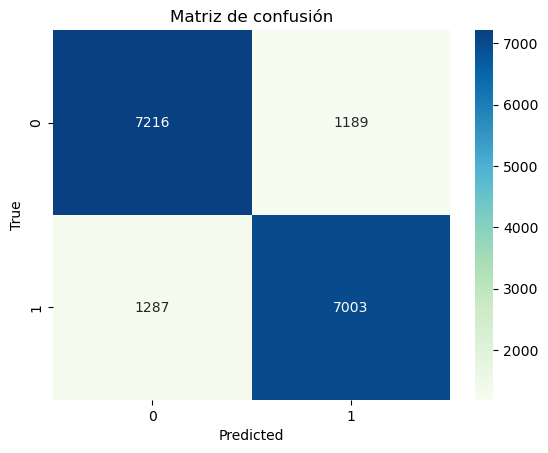

1218/1218 [==============================] - 0s 298us/step
Accuracy: 0.8523167757669106
Recall: 0.8507765023632681
Precision: 0.8504672897196262
f1 score: 0.8506218679406953


In [ ]:
modelo = keras.Sequential([
   keras.layers.Dense(256, input_shape=(x_train_escalado_min_max.shape[1],), activation='relu', kernel_regularizer=keras.regularizers.l2(0.0004)),
   keras.layers.Dense(1, activation='sigmoid'),

])

modelo.compile(optimizer=keras.optimizers.legacy.SGD(learning_rate=0.01),
             loss='binary_crossentropy',
             metrics=['accuracy'], 
             
             )

modelo.fit(x_train_escalado_min_max, y_train, epochs=60)

y_prediccion = modelo.predict(x_test_escalado_min_max)
mostrar_scores(y_test, y_prediccion.round())

tabla = confusion_matrix(y_test, y_prediccion.round())
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


y_prediccion_train = modelo.predict(x_train_escalado_min_max)
mostrar_scores(y_train, y_prediccion_train.round())

Como podemos ver este modelo esta bastante balanceado, sin embargo no predice muy bien en general.

### Busqueda de hiperparams

In [128]:
def crear_modelo(optimizer='adam', kernel_initializer='glorot_uniform', activation='relu', neurons=1):
    modelo = keras.Sequential([
        keras.layers.Dense(neurons, input_shape=(x_train_escalado_min_max.shape[1],), activation=activation, kernel_initializer=kernel_initializer),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation='sigmoid')

    ])

    modelo.compile(optimizer=optimizer,
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

    return modelo

modelo = KerasClassifier(build_fn=crear_modelo, verbose=0)

param_grid = {

    'batch_size': [16, 32, 64, 128],
    'epochs': [10, 50, 100],
    'optimizer': ['adam'],
    'activation': ['relu', 'tanh', 'sigmoid'],
    'neurons': [128, 256, 512],
    'kernel_initializer': ['glorot_uniform', 'normal', 'uniform']
}

random_search = RandomizedSearchCV(modelo, param_grid, cv=5, n_iter=10, scoring='accuracy', verbose=10, n_jobs=-1)
random_search.fit(x_train_escalado_min_max, y_train)

print(random_search.best_params_)
print(random_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[CV 1/5; 1/10] START activation=relu, batch_size=32, epochs=50, kernel_initializer=normal, neurons=256, optimizer=sdg[CV 4/5; 1/10] START activation=relu, batch_size=32, epochs=50, kernel_initializer=normal, neurons=256, optimizer=sdg

[CV 3/5; 1/10] START activation=relu, batch_size=32, epochs=50, kernel_initializer=normal, neurons=256, optimizer=sdg
[CV 2/5; 2/10] START activation=relu, batch_size=32, epochs=10, kernel_initializer=uniform, neurons=512, optimizer=sdg
[CV 3/5; 2/10] START activation=relu, batch_size=32, epochs=10, kernel_initializer=uniform, neurons=512, optimizer=sdg
[CV 1/5; 2/10] START activation=relu, batch_size=32, epochs=10, kernel_initializer=uniform, neurons=512, optimizer=sdg
[CV 5/5; 1/10] START activation=relu, batch_size=32, epochs=50, kernel_initializer=normal, neurons=256, optimizer=sdg
[CV 2/5; 1/10] START activation=relu, batch_size=32, epochs=50, kernel_initializer=normal, neurons=256, optimizer=sdg
[CV 2/5; 1/10] END activation=relu, batch_size=32, ep

2023-10-31 10:59:53.158901: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-10-31 10:59:53.247927: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-10-31 10:59:53.292797: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-10-31 10:59:53.293468: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-10-31 10:59:53.423561: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-10-31 10:59:53.430147: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-10-31 10:59:53.448450: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-10-31 10:59:53.553210: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


244/244 [==============================] - 1s 3ms/step
[CV 3/5; 3/10] END activation=tanh, batch_size=64, epochs=50, kernel_initializer=normal, neurons=256, optimizer=adam;, score=0.852 total time= 1.6min
[CV 4/5; 3/10] END activation=tanh, batch_size=64, epochs=50, kernel_initializer=normal, neurons=256, optimizer=adam;, score=0.860 total time= 1.6min
[CV 5/5; 4/10] START activation=sigmoid, batch_size=16, epochs=50, kernel_initializer=glorot_uniform, neurons=128, optimizer=adam
[CV 1/5; 5/10] START activation=relu, batch_size=128, epochs=10, kernel_initializer=normal, neurons=128, optimizer=sdg
[CV 5/5; 3/10] END activation=tanh, batch_size=64, epochs=50, kernel_initializer=normal, neurons=256, optimizer=adam;, score=0.860 total time= 1.6min
[CV 2/5; 5/10] START activation=relu, batch_size=128, epochs=10, kernel_initializer=normal, neurons=128, optimizer=sdg
[CV 1/5; 5/10] END activation=relu, batch_size=128, epochs=10, kernel_initializer=normal, neurons=128, optimizer=sdg;, score=na

/Users/juampi/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
30 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/juampi/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/juampi/anaconda3/lib/python3.11/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/juampi/anaconda3/lib/python3.11/site-packages/keras/wrappers/scikit_learn.py", line 16

{'optimizer': 'adam', 'neurons': 256, 'kernel_initializer': 'normal', 'epochs': 50, 'batch_size': 64, 'activation': 'tanh'}
0.8570658452060069


Luego de esta busqueda podemos ver los  resultados de este nuevo modelo tanto con los datos de train y los de test, para ver si realmente hay una mejora y si el modelo no esta overfiteado.

522/522 [==============================] - 0s 342us/step
Accuracy: 0.8630128781072177
Recall: 0.8676718938480097
Precision: 0.8580460455684122
f1 score: 0.8628321237929586


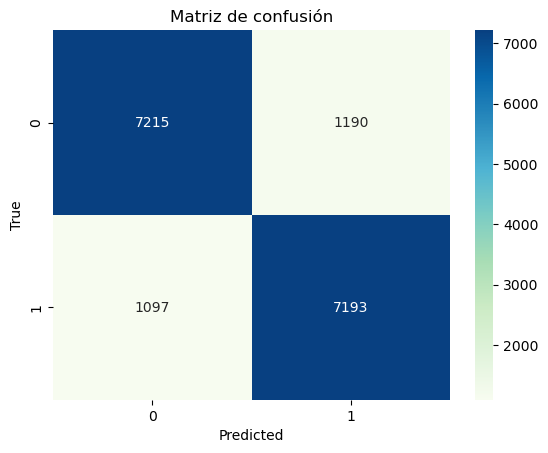

1218/1218 [==============================] - 0s 386us/step
Accuracy: 0.871030676421512
Recall: 0.8809016776606243
Precision: 0.8613071961809964
f1 score: 0.8709942481511915


In [168]:
y_prediccion = random_search.predict(x_test_escalado_min_max)
mostrar_scores(y_test, y_prediccion)

tabla = confusion_matrix(y_test, y_prediccion)
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

y_prediccion_train = random_search.predict(x_train_escalado_min_max)
mostrar_scores(y_train, y_prediccion_train)

En este modelo ambas metricas estan balanceadas, sin embargo presenta cierto overfitting, vamos a ver si podemos mejorar eso manteniendo el balance de las metricas.

### Armado del mejor modelo

Luego de haber testeado con multiples parametros, vamos a crear una red neuronales tomando los que mejor resultados nos den y predictear a kaggle.

Epoch 1/60
1218/1218 [==============================] - 1s 662us/step - loss: 0.4081 - accuracy: 0.8164
Epoch 2/60
1218/1218 [==============================] - 1s 574us/step - loss: 0.3619 - accuracy: 0.8354
Epoch 3/60
1218/1218 [==============================] - 1s 568us/step - loss: 0.3537 - accuracy: 0.8391
Epoch 4/60
1218/1218 [==============================] - 1s 572us/step - loss: 0.3474 - accuracy: 0.8416
Epoch 5/60
1218/1218 [==============================] - 1s 553us/step - loss: 0.3430 - accuracy: 0.8455
Epoch 6/60
1218/1218 [==============================] - 1s 629us/step - loss: 0.3390 - accuracy: 0.8487
Epoch 7/60
1218/1218 [==============================] - 1s 687us/step - loss: 0.3357 - accuracy: 0.8489
Epoch 8/60
1218/1218 [==============================] - 1s 597us/step - loss: 0.3323 - accuracy: 0.8520
Epoch 9/60
1218/1218 [==============================] - 1s 544us/step - loss: 0.3293 - accuracy: 0.8522
Epoch 10/60
1218/1218 [==============================] - 1s 653u

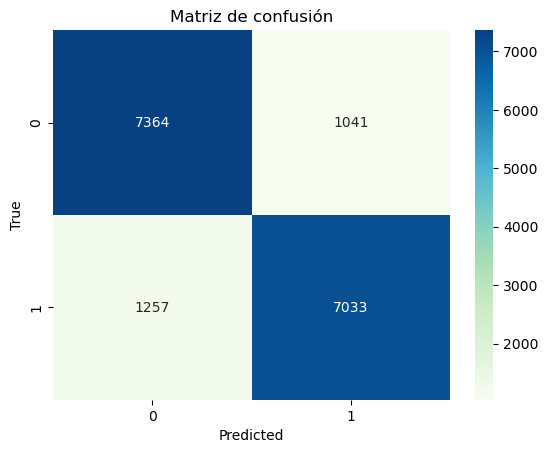

1218/1218 [==============================] - 0s 355us/step
Accuracy: 0.8783211397766654
Recall: 0.8687996675842726
Precision: 0.8831107122116044
f1 score: 0.8758967377074933


In [166]:
modelo = keras.Sequential([
   keras.layers.Dense(256, input_shape=(x_train_escalado_min_max.shape[1],), activation='relu', kernel_regularizer=keras.regularizers.l2(0.0004)),
   keras.layers.Dense(1, activation='sigmoid'),

])

modelo.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

modelo.fit(x_train_escalado_min_max, y_train, epochs=60)

y_prediccion = modelo.predict(x_test_escalado_min_max)
mostrar_scores(y_test, y_prediccion.round())
tabla = confusion_matrix(y_test, y_prediccion.round())
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


y_prediccion_train = modelo.predict(x_train_escalado_min_max)
mostrar_scores(y_train, y_prediccion_train.round())

Como podemos ver el modelo empeoro tanto en el f1 score, como el balanceo y el overfitting, vamos a probar con otro modelo.

#### Red neuronal con muchas capas y dropout


Vamos a probar agregando mas capas y epochs para ver si mejora el modelo, para evitar el overfitting realizamos dropouts.

Epoch 1/50
1218/1218 [==============================] - 2s 1ms/step - loss: 0.4662 - accuracy: 0.8191
Epoch 2/50
1218/1218 [==============================] - 1s 1ms/step - loss: 0.3952 - accuracy: 0.8370
Epoch 3/50
1218/1218 [==============================] - 1s 1ms/step - loss: 0.3760 - accuracy: 0.8428
Epoch 4/50
1218/1218 [==============================] - 1s 1ms/step - loss: 0.3616 - accuracy: 0.8476
Epoch 5/50
1218/1218 [==============================] - 1s 1ms/step - loss: 0.3540 - accuracy: 0.8480
Epoch 6/50
1218/1218 [==============================] - 1s 1ms/step - loss: 0.3470 - accuracy: 0.8535
Epoch 7/50
1218/1218 [==============================] - 2s 1ms/step - loss: 0.3434 - accuracy: 0.8540
Epoch 8/50
1218/1218 [==============================] - 1s 1ms/step - loss: 0.3389 - accuracy: 0.8568
Epoch 9/50
1218/1218 [==============================] - 1s 1ms/step - loss: 0.3370 - accuracy: 0.8559
Epoch 10/50
1218/1218 [==============================] - 2s 1ms/step - loss: 0.335

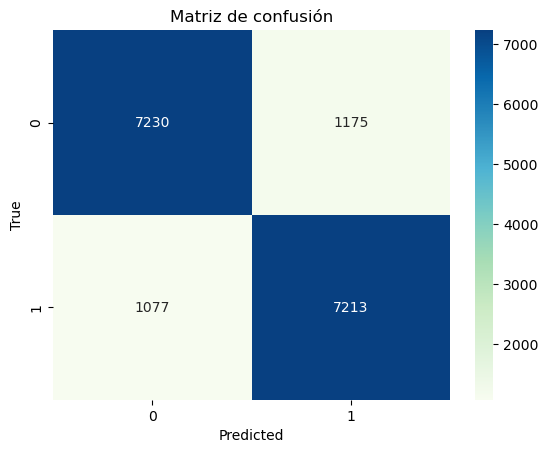

1218/1218 [==============================] - 0s 375us/step
Accuracy: 0.8769862662045951
Recall: 0.886355373188594
Precision: 0.8676089277543342
f1 score: 0.8768819690663379


In [159]:
modelo = keras.Sequential([
    keras.layers.Dense(256, input_shape=(x_train_escalado_min_max.shape[1],), activation='relu', kernel_regularizer=keras.regularizers.l1_l2(0.00004, 0.0005), kernel_initializer='normal'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l1(0.00004)),
    keras.layers.Dense(64, activation='relu',  kernel_regularizer=keras.regularizers.l1(0.00004)),
    keras.layers.Dense(1, activation='sigmoid'),
    
    ])

modelo.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

modelo.fit(x_train_escalado_min_max, y_train, epochs=50)
y_prediccion = modelo.predict(x_test_escalado_min_max)

mostrar_scores(y_test, y_prediccion.round())

tabla = confusion_matrix(y_test, y_prediccion.round())
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


y_prediccion_train = modelo.predict(x_train_escalado_min_max)

mostrar_scores(y_train, y_prediccion_train.round())



En nuestro modelo final podemos ver como a pesar que haya cierto overfitting, el recall y precision son muy similares, al igual con el f1, y la cantidad de positivos y negativos esta equitativamente balanceada.

## Evaluación con el dataset de test

In [81]:
df_test = pd.read_csv('https://drive.usercontent.google.com/download?id=1ruDne6JVJTwK0TbDNQEUfUtoxA6gVTiy&export=download&authuser=0&confirm=t&uuid=2892328a-d7d8-47c7-98e1-3e69ef723100&at=APZUnTU5aCf9tHsTaF3PM7aD9Lym:1695760323667')

df_test.shape

(26535, 31)

### Imputacion de valores faltantes

Primero imputamos el dataset tal cual lo hicimos con el de train, sin inspeccionar casos bordes para evitar data leakage.

In [82]:
nuevas_columnas = {
    'arrival_date_year' : 'year',
    'arrival_date_month' : 'month',
    'arrival_date_week_number' : 'week_number',
    'arrival_date_day_of_month' : 'day_of_month',
    'meal' : 'meal_type',
    'agent' : 'agent_id',
    'adr' : 'average_daily_rate'
}
df_test.rename(columns = nuevas_columnas, inplace = True)

Imputación de children, company y adults

In [83]:
df_test['total_nights'] = df_test['stays_in_week_nights'] + df_test['stays_in_weekend_nights']
df_test['children'].fillna(0, inplace=True)
df_test['total_people'] = df_test['adults'] + df_test['children'] + df_test['babies']
df_test['meal_type'].replace(['SC', 'Undefined'], 'NoMeal', inplace=True)
df_test.drop(columns=['company'], inplace=True)

Imputación de agent id

In [84]:
for index, row in df_test.iterrows():
    if (pd.isna(row['agent_id'])) & (row['distribution_channel'] == 'Direct'):
        df_test.loc[index, 'agent_id'] = -1

for index, row in df_test.iterrows():
    if (not pd.isna(row['agent_id'])) or (row['distribution_channel'] == 'Direct'):
        continue
    if row['hotel'] == 'City Hotel':
        if row['country'] == 'PRT':
            df_test.loc[index, 'agent_id'] = 1.0
        else: 
            df_test.loc[index, 'agent_id'] = 9.0
    else:
        df_test.loc[index, 'agent_id'] = 240.0

Imputación de country

In [85]:
for index, row in df_test.iterrows():
    if pd.isna(row['country']) and row['deposit_type'] == 'Non Refund':
        df_test.loc[index, 'country'] = 'PRT'

for index, row in df_test.iterrows():
    if pd.isna(row['country']) and (row['market_segment'] == 'Corporate' or row['market_segment'] == 'Offline TA/TO' or row['market_segment'] == 'Direct'):
        df_test.loc[index, 'country'] = 'PRT'

Prediccion final

In [87]:
df_encode = df_test.copy()

df_encode['agent_id'] = df_test['agent_id'].apply(lambda x: x if x in list(df_agentes_mayoritarios['agent_id']) else 'Otros')
df_encode['country'] = df_test['country'].apply(lambda x: x if x in list(df_paises_mayoritarios['country']) else 'Otros')

columns.remove('is_canceled')
df_filtrado = df_encode[columns]
columns.append('is_canceled')
df_test_con_dummies = pd.get_dummies(df_filtrado, columns=dummy_columns, drop_first=True).reset_index(drop=True)

df_test_con_dummies['cuarto_correcto'] = df_encode['reserved_room_type'] == df_encode['assigned_room_type']
df_test_con_dummies['cuarto_correcto'] = df_test_con_dummies['cuarto_correcto'].apply(lambda x: 1 if x == True else 0)




830/830 [==============================] - 0s 398us/step


In [161]:
mejor_modelo = modelo

test_scaled = escalador.transform(df_test_con_dummies)
y_pred= mejor_modelo.predict(test_scaled)

y_pred_int  = y_pred.round().astype(int)

df_prediccion = pd.DataFrame(y_pred_int, columns=['is_canceled'])
df_prediccion['id'] = df_test['id']
df_prediccion = df_prediccion[['id', 'is_canceled']]


df_prediccion.to_csv('prediccion.csv', index=False)

830/830 [==============================] - 0s 297us/step
